In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

In [11]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [12]:
train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')
test_data = pd.read_csv('test_data.csv', index_col='Claim Identifier')

/var/folders/cb/8gnf1rrd7914vbmqtgrt2mmm0000gn/T/ipykernel_8638/3470921380.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')


In [13]:
#drop target variable
df = train_data.drop(columns='Claim Injury Type')

In [14]:
#duplicated values
df.duplicated().sum()

18351

In [15]:

only_assembly_date = df.drop(columns=['Assembly Date']).isnull().all(axis=1) & df['Assembly Date'].notnull()


num_only_assembly_date_filled = only_assembly_date.sum()
print(f"Number of rows with only 'Assembly Date' filled: {num_only_assembly_date_filled}")

Number of rows with only 'Assembly Date' filled: 19445


In [16]:
df.isnull().sum()/df.shape[0]*100

Accident Date                           3.898084
Age at Injury                           3.276487
Alternative Dispute Resolution          3.276487
Assembly Date                           0.000000
Attorney/Representative                 3.276487
Average Weekly Wage                     8.104187
Birth Year                              8.176137
C-2 Date                                5.729850
C-3 Date                               68.449174
Carrier Name                            3.276487
Carrier Type                            3.276487
County of Injury                        3.276487
COVID-19 Indicator                      3.276487
District Name                           3.276487
First Hearing Date                     74.590502
Gender                                  3.276487
IME-4 Count                            77.622664
Industry Code                           4.954412
Industry Code Description               4.954412
Medical Fee Region                      3.276487
OIICS Nature of Inju

In [17]:
train_data['C-3 Date'].value_counts(dropna=False)
len(train_data['C-3 Date'].unique())

1649

In [18]:
train_data['First Hearing Date'].value_counts(dropna=False)

print(len(train_data['First Hearing Date'].unique()))

1095


In [19]:
train_data['IME-4 Count'].value_counts(dropna=False)

print(len(train_data['IME-4 Count'].unique()))

42


In [20]:
df.describe(include='O')

,Accident Date,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,WCIO Nature of Injury Description,WCIO Part Of Body Description,Zip Code,WCB Decision
count,570337,574026,593471,574026,559466,187245,574026,574026,574026,574026,574026,150798,574026,564068,574026,558386,558369,556944,545389,574026
unique,5539,3,1096,2,2475,1648,2046,8,63,2,8,1094,4,20,5,74,56,54,10060,1
top,2020-03-01,N,2020-03-06,N,2021-05-11,2021-04-21,STATE INSURANCE FUND,1A. PRIVATE,SUFFOLK,N,NYC,2022-04-15,M,HEALTH CARE AND SOCIAL ASSISTANCE,IV,LIFTING,STRAIN OR TEAR,LOWER BACK AREA,11236,Not Work Related
freq,1245,571412,1422,392291,1847,350,111144,285368,60430,546505,270779,440,335218,114339,265981,46610,153373,51862,3302,574026


In [21]:
#function to transform Y and N into boolean while preserving the NaNs
def transform_strings_in_bool(df, col_names):
    for col_name in col_names:
        df[col_name] = df[col_name].map({'Y': True, 'N': False, np.nan: np.nan})
    return df

In [22]:
# Agreement Reached only has values of  0s and 1s so lets convert it to boolean
df['Agreement Reached'] = df['Agreement Reached'].astype("boolean")

In [23]:

df = transform_strings_in_bool(df, ['Attorney/Representative','COVID-19 Indicator'])
print(df['Attorney/Representative'].unique(), df['COVID-19 Indicator'].unique())

[False True nan] [False nan True]


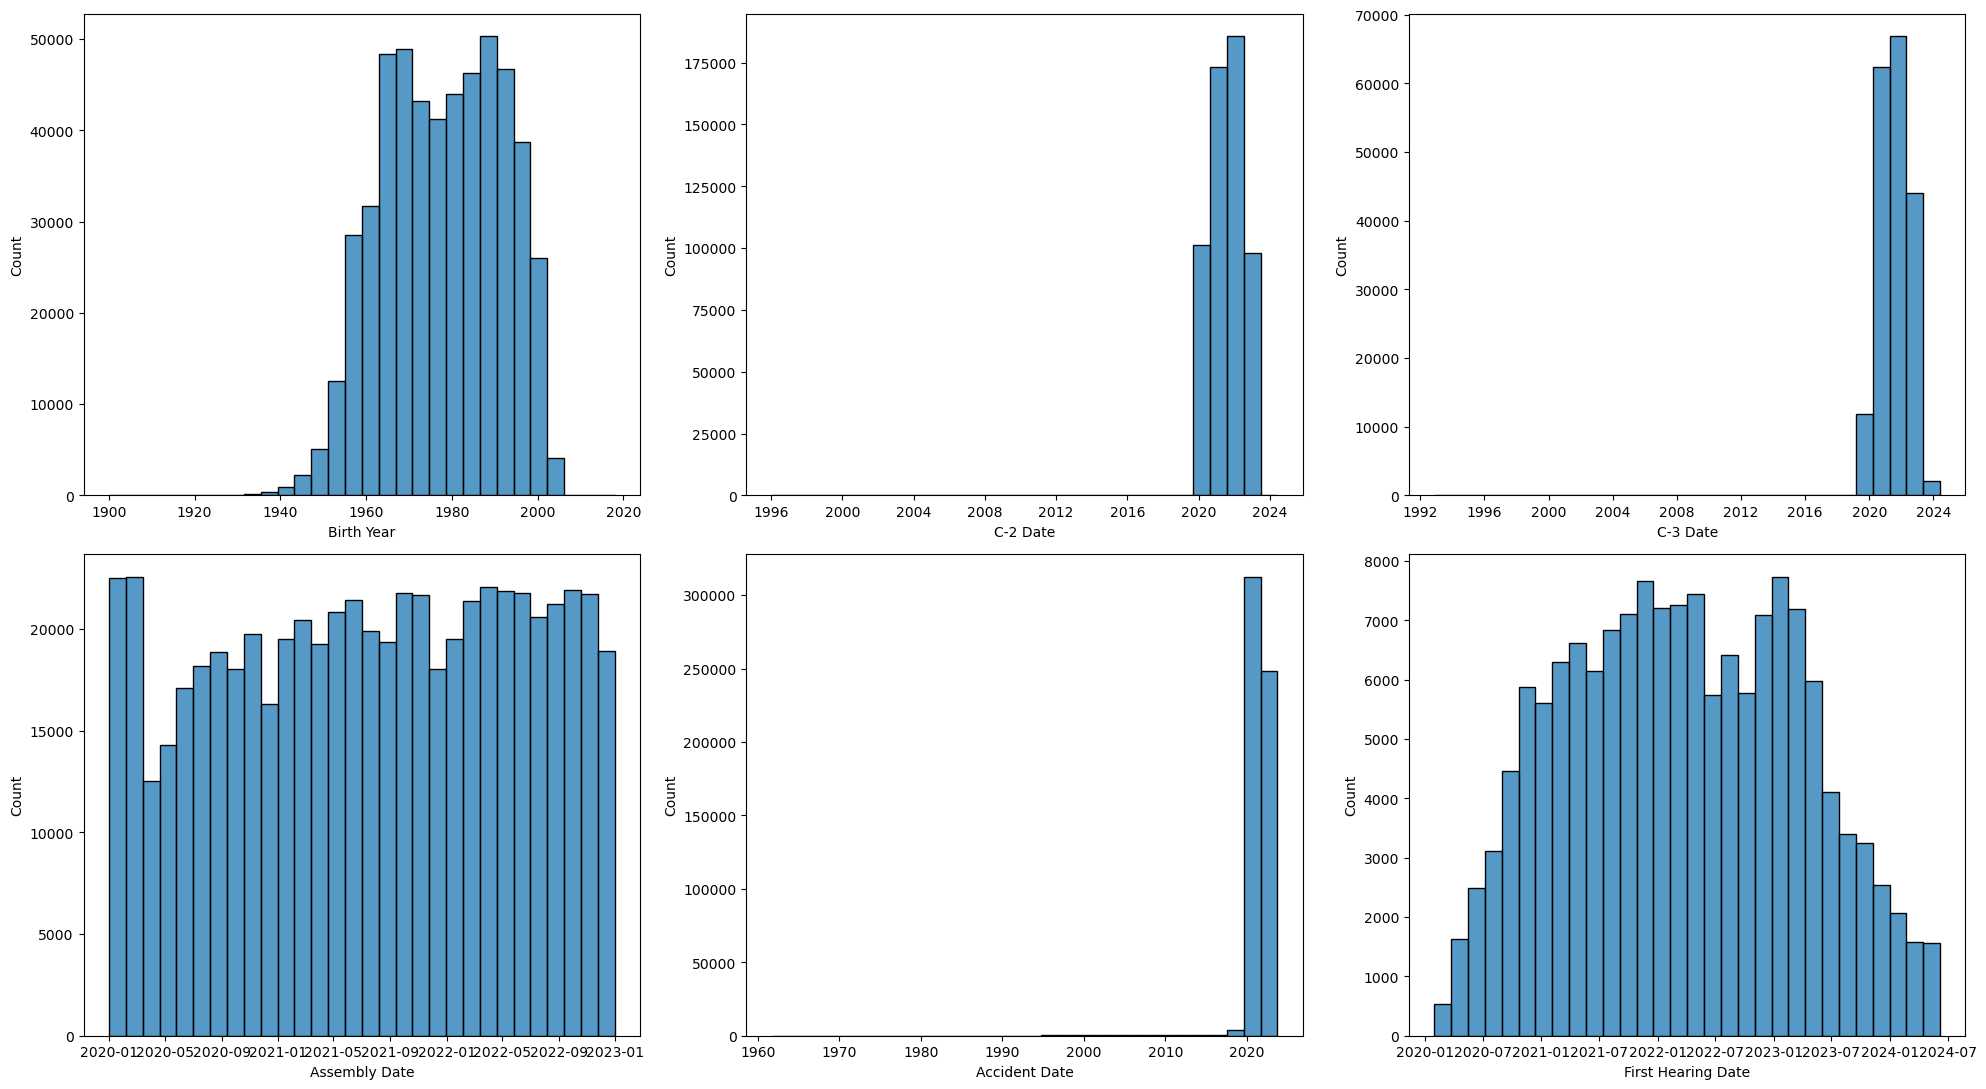

In [24]:
outlier_date = train_data.copy()
for col in outlier_date.columns:
    if 'Date' in col:
        outlier_date[col] = pd.to_datetime(outlier_date[col], format='%Y-%m-%d')
    elif 'Year' in col:
        outlier_date[col] = outlier_date[col].replace(0.0, np.nan)
        outlier_date[col] = pd.to_datetime(outlier_date[col].dropna().astype(int).astype(str), format='%Y', errors='coerce')

features = ['Birth Year','C-2 Date','C-3 Date','Assembly Date','Accident Date','First Hearing Date']

sp_rows = 2
sp_cols = 3

fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 11), tight_layout=True)

for ax, feat in zip(axes.flatten(), features):
    sns.histplot(outlier_date[feat], ax=ax, bins=30)


title = "Datetime Variables' Histograms"

plt.show()

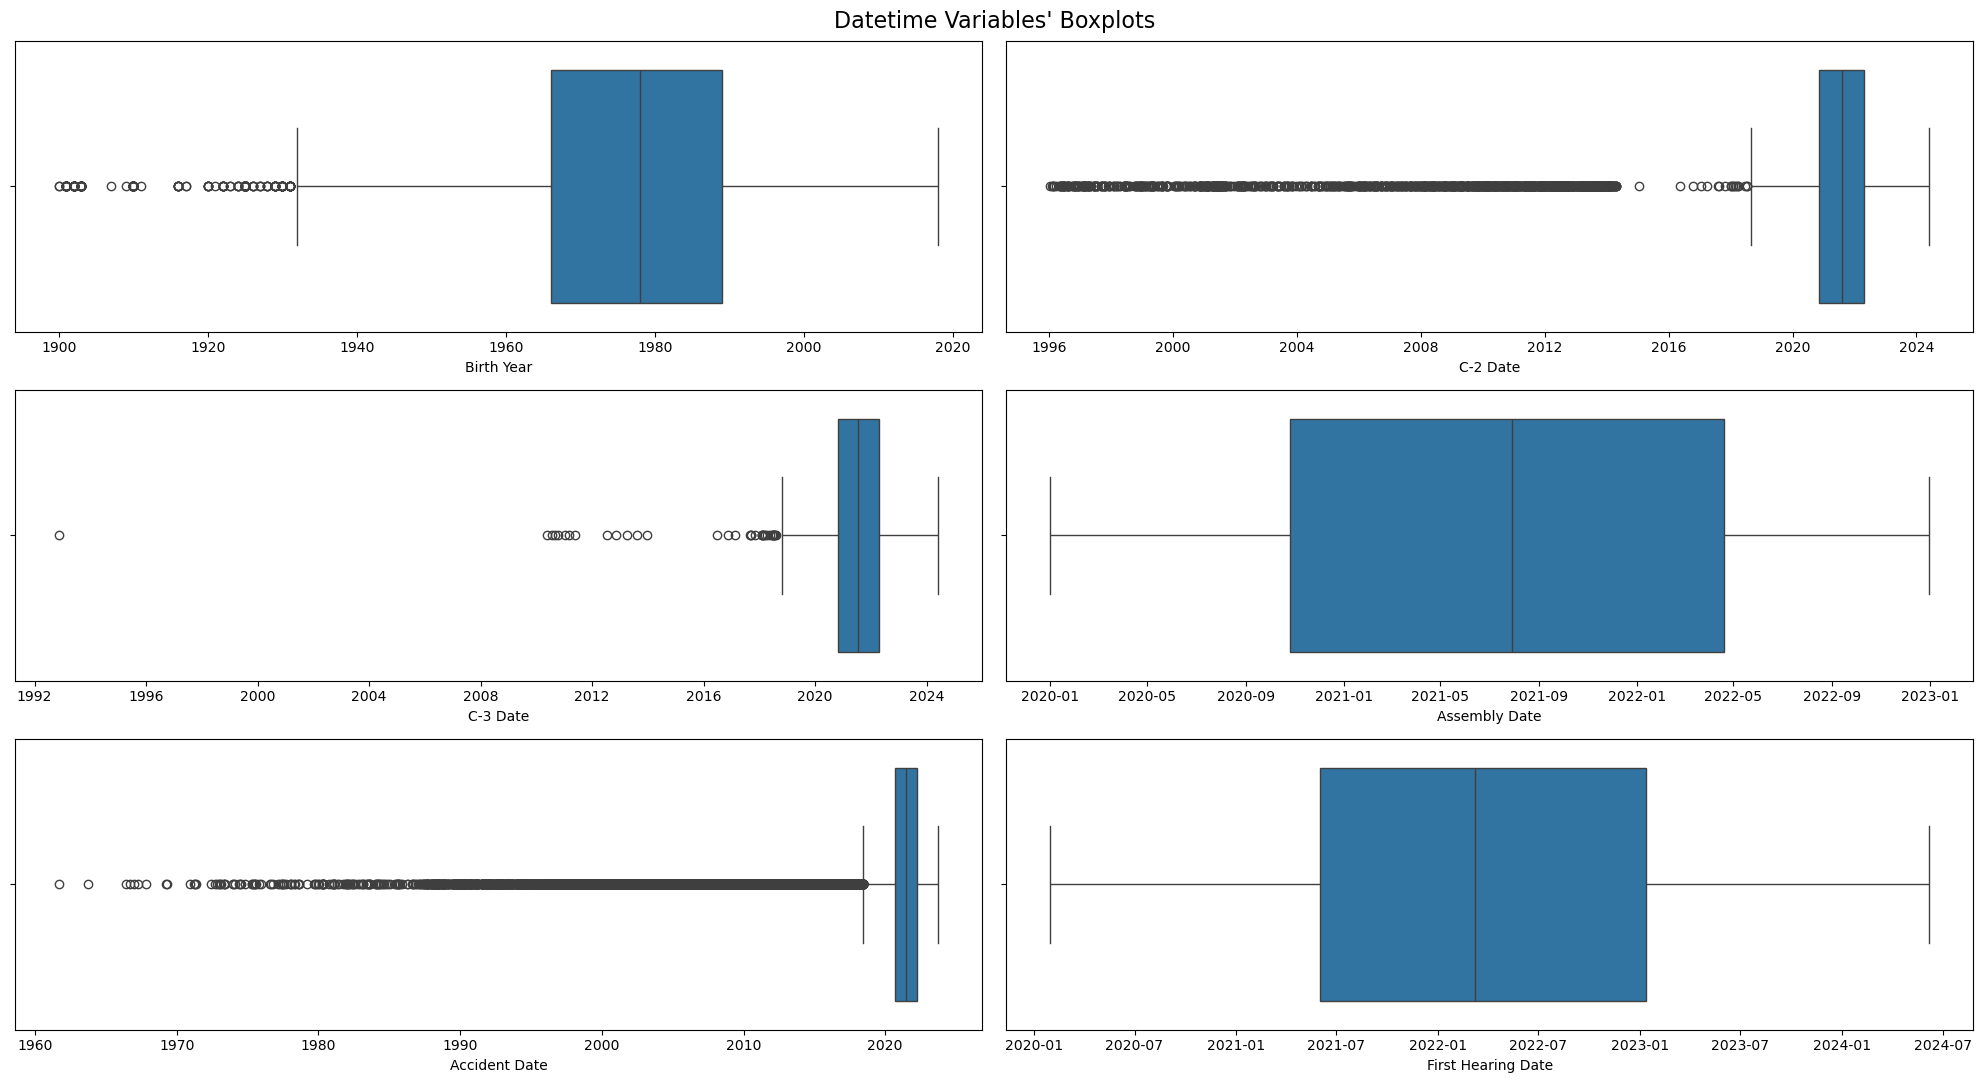

In [25]:
sp_rows = 3
sp_cols = 2

fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 11), tight_layout=True)

for ax, feat in zip(axes.flatten(), features):
    sns.boxplot(x=outlier_date[feat], ax=ax)


title = "Datetime Variables' Boxplots"
plt.suptitle(title, fontsize=16)
plt.show()

In [26]:
df['Accident Date'].head()

Claim Identifier
5393875      2019-12-30
5393091      2019-08-30
5393889      2019-12-06
957648180           NaN
5393887      2019-12-30
Name: Accident Date, dtype: object

In [27]:
# converts the date columns to datetime format
for col in train_data.columns:
    # fist we convert all columns containing the word 'Date' to datetime format
    if 'Date' in col:
        train_data[col] = pd.to_datetime(train_data[col], format='%Y-%m-%d')


train_data

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5393875,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaT,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaT,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
5393091,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
5393889,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaT,INDEMNITY INSURANCE CO OF,1A. PRIVATE,4. TEMPORARY,ORANGE,N,ALBANY,NaT,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
957648180,NaT,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5393887,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaT,STATE INSURANCE FUND,2A. SIF,2. NON-COMP,DUTCHESS,N,ALBANY,NaT,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327160035,NaT,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6165075,2022-12-13,72.0,N,2022-12-31,N,0.00,1950.0,2022-12-31,NaT,TECHNOLOGY INSURANCE CO. INC.,1A. PRIVATE,2. NON-COMP,SULLIVAN,N,BINGHAMTON,NaT,F,NaN,48.0,TRANSPORTATION AND WAREHOUSING,I,NaN,25.0,FROM DIFFERENT LEVEL (ELEVATION),90.0,MULTIPLE PHYSICAL INJURIES ONLY,-9.0,MULTIPLE,12779,0.0,Not Work Related,3.0
249875936,NaT,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
def convert_dates_to_timestamps(df):
    """
    Converts all columns in the DataFrame that contain 'Date' in their name
    to timestamps (seconds since epoch).

    Parameters:
    df (pd.DataFrame): The DataFrame containing date columns.

    Returns:
    pd.DataFrame: DataFrame with 'Date' columns converted to timestamps.
    """
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()

    for col in df.columns:
        if 'Date' in col:
            # Convert the column to datetime, coerce invalid parsing to NaT
            df[col] = pd.to_datetime(df[col], errors='coerce')

#Convert to timestamp only for valid datetime values
            df[col] = df[col].apply(lambda x: x.timestamp() if pd.notnull(x) else np.nan)

    return df

In [29]:
train_data = convert_dates_to_timestamps(train_data)
test_data = convert_dates_to_timestamps(test_data)

train_data.describe(include='all')

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
count,5.703370e+05,574026.000000,574026,5.934710e+05,574026,5.453750e+05,544948.000000,5.594660e+05,1.872450e+05,574026,574026,574026,574026,574026,574026,1.507980e+05,574026,132803.000000,564068.000000,564068,574026,0.0,558386.000000,558386,558369.000000,558369,556944.000000,556944,545389,574026.000000,574026,574026.000000
unique,NaN,NaN,3,NaN,2,NaN,NaN,NaN,NaN,2046,8,8,63,2,8,NaN,4,NaN,NaN,20,5,NaN,NaN,74,NaN,56,NaN,54,10060,NaN,1,NaN
top,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,STATE INSURANCE FUND,1A. PRIVATE,2. NON-COMP,SUFFOLK,N,NYC,NaN,M,NaN,NaN,HEALTH CARE AND SOCIAL ASSISTANCE,IV,NaN,NaN,LIFTING,NaN,STRAIN OR TEAR,NaN,LOWER BACK AREA,11236,NaN,Not Work Related,NaN
freq,NaN,NaN,571412,NaN,392291,NaN,NaN,NaN,NaN,111144,285368,291078,60430,546505,270779,NaN,335218,NaN,NaN,114339,265981,NaN,NaN,46610,NaN,153373,NaN,51862,3302,NaN,574026,NaN
mean,1.619644e+09,42.114270,NaN,1.626665e+09,NaN,4.910883e+02,1886.767604,1.626466e+09,1.627335e+09,NaN,NaN,NaN,NaN,NaN,NaN,1.647666e+09,NaN,3.207337,58.645305,NaN,NaN,NaN,54.381143,NaN,41.013839,NaN,39.738146,NaN,NaN,0.046665,NaN,3.006559
std,5.908936e+07,14.256432,NaN,2.721032e+07,NaN,6.092918e+03,414.644423,3.513655e+07,2.832608e+07,NaN,NaN,NaN,NaN,NaN,NaN,3.144186e+07,NaN,2.832303,19.644175,NaN,NaN,NaN,25.874281,NaN,22.207521,NaN,22.365940,NaN,NaN,0.210921,NaN,2.000801
min,-2.625696e+08,0.000000,NaN,1.577837e+09,NaN,0.000000e+00,0.000000,8.214048e+08,7.216128e+08,NaN,NaN,NaN,NaN,NaN,NaN,1.580342e+09,NaN,1.000000,11.000000,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,-9.000000,NaN,NaN,0.000000,NaN,0.000000
25%,1.600042e+09,31.000000,NaN,1.603670e+09,NaN,0.000000e+00,1965.000000,1.604621e+09,1.603757e+09,NaN,NaN,NaN,NaN,NaN,NaN,1.622506e+09,NaN,1.000000,45.000000,NaN,NaN,NaN,31.000000,NaN,16.000000,NaN,33.000000,NaN,NaN,0.000000,NaN,1.000000
50%,1.624752e+09,42.000000,NaN,1.627517e+09,NaN,0.000000e+00,1977.000000,1.628467e+09,1.626826e+09,NaN,NaN,NaN,NaN,NaN,NaN,1.646784e+09,NaN,2.000000,61.000000,NaN,NaN,NaN,56.000000,NaN,49.000000,NaN,38.000000,NaN,NaN,0.000000,NaN,3.000000
75%,1.647821e+09,54.000000,NaN,1.650326e+09,NaN,8.410000e+02,1989.000000,1.650931e+09,1.650413e+09,NaN,NaN,NaN,NaN,NaN,NaN,1.673395e+09,NaN,4.000000,71.000000,NaN,NaN,NaN,75.000000,NaN,52.000000,NaN,53.000000,NaN,NaN,0.000000,NaN,5.000000


In [30]:
train_data = train_data[~(train_data.drop(columns=['Assembly Date']).isna().all(axis=1) & train_data['Assembly Date'].notna())]
X_test = test_data[~(test_data.drop(columns=['Assembly Date']).isna().all(axis=1) & test_data['Assembly Date'].notna())]

In [31]:
only_assembly_date = train_data.drop(columns=['Assembly Date']).isnull().all(axis=1) & df['Assembly Date'].notnull()


num_only_assembly_date_filled = only_assembly_date.sum()
print(f"Number of rows with only 'Assembly Date' filled: {num_only_assembly_date_filled}")

Number of rows with only 'Assembly Date' filled: 0


In [32]:
X = train_data.drop(columns=['Claim Injury Type', 'WCB Decision', 'Agreement Reached'])
y = train_data['Claim Injury Type']
wcb_decision = train_data['WCB Decision']
agreement_reached = train_data['Agreement Reached']

In [33]:
y.isna().sum()

0

In [34]:
# split the data into training and testing sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [35]:
# drop OIICS Nature of Injury Description
X_train = X_train.drop(columns=['OIICS Nature of Injury Description'])
X_val = X_val.drop(columns=['OIICS Nature of Injury Description'])
X_test = X_test.drop(columns=['OIICS Nature of Injury Description'])

In [36]:
# KNNNNNb

In [37]:
X_train_knn = X_train.copy()
X_val_knn = X_val.copy()
X_test_knn = X_test.copy()

In [38]:
X_train_knn["IME-4 Count"].fillna(0, inplace=True)
X_val_knn["IME-4 Count"].fillna(0, inplace=True)
X_test_knn["IME-4 Count"].fillna(0, inplace=True)

/var/folders/cb/8gnf1rrd7914vbmqtgrt2mmm0000gn/T/ipykernel_8638/4214573977.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_knn["IME-4 Count"].fillna(0, inplace=True)
/var/folders/cb/8gnf1rrd7914vbmqtgrt2mmm0000gn/T/ipykernel_8638/4214573977.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [39]:
X_train_knn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 459220 entries, 5785935 to 6027959
Data columns (total 28 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Accident Date                      456264 non-null  float64
 1   Age at Injury                      459220 non-null  float64
 2   Alternative Dispute Resolution     459220 non-null  object 
 3   Assembly Date                      459220 non-null  float64
 4   Attorney/Representative            459220 non-null  object 
 5   Average Weekly Wage                436244 non-null  float64
 6   Birth Year                         435978 non-null  float64
 7   C-2 Date                           447585 non-null  float64
 8   C-3 Date                           149655 non-null  float64
 9   Carrier Name                       459220 non-null  object 
 10  Carrier Type                       459220 non-null  object 
 11  County of Injury                   45

In [40]:
X_train_knn.isnull().sum()

Accident Date                          2956
Age at Injury                             0
Alternative Dispute Resolution            0
Assembly Date                             0
Attorney/Representative                   0
Average Weekly Wage                   22976
Birth Year                            23242
C-2 Date                              11635
C-3 Date                             309565
Carrier Name                              0
Carrier Type                              0
County of Injury                          0
COVID-19 Indicator                        0
District Name                             0
First Hearing Date                   338679
Gender                                    0
IME-4 Count                               0
Industry Code                          7976
Industry Code Description              7976
Medical Fee Region                        0
WCIO Cause of Injury Code             12494
WCIO Cause of Injury Description      12494
WCIO Nature of Injury Code      

In [41]:
# Step 1: Identify Columns with Missing Values
missing_columns = X_train_knn.columns[X_train_knn.isnull().any()]
print("Columns with missing values:", missing_columns)

Columns with missing values: Index(['Accident Date', 'Average Weekly Wage', 'Birth Year', 'C-2 Date',
       'C-3 Date', 'First Hearing Date', 'Industry Code',
       'Industry Code Description', 'WCIO Cause of Injury Code',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Code',
       'WCIO Part Of Body Description', 'Zip Code'],
      dtype='object')


In [42]:
# List of datasets
datasets = {'train': X_train_knn, 'val': X_val_knn, 'test': X_test_knn}
label_encoders = {}  # Store encoders for each column

# Step 1: Ensure consistent encoding for all categorical columns
for column in X_train_knn.columns:
    # Check if the column contains any non-numeric (string) values
    if X_train_knn[column].dtype == 'object' or X_train_knn[column].apply(lambda x: isinstance(x, str)).any():
        
        # Initialize Label Encoder and fit on the training data
        le = LabelEncoder()
        # Convert all entries to string to ensure consistent encoding
        X_train_knn[column] = X_train_knn[column].astype(str)
        X_train_knn[column] = le.fit_transform(X_train_knn[column])
        
        # Store encoder for future use
        label_encoders[column] = le

        # Apply the encoder to validation and test datasets with unseen value handling
        for name in ['val', 'test']:
            # Replace any unseen labels with NaN to avoid KeyErrors
            datasets[name][column] = datasets[name][column].astype(str).apply(lambda x: x if x in le.classes_ else np.nan)
            # Add NaN as a class label to handle unseen values
            le.classes_ = np.append(le.classes_, np.nan)
            # Transform the column in the current dataset
            datasets[name][column] = le.transform(datasets[name][column])

In [43]:
# Step 2: Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5, weights="uniform", metric="nan_euclidean")


print("Knn completed on training, validation, and test sets.")

Knn completed on training, validation, and test sets.


In [ ]:
# Impute missing values in the training, validation, and test sets
X_train_knn_imputed = pd.DataFrame(imputer.fit_transform(X_train_knn), columns=X_train_knn.columns)
X_val_knn_imputed = pd.DataFrame(imputer.transform(X_val_knn), columns=X_val_knn.columns)
X_test_knn_imputed = pd.DataFrame(imputer.transform(X_test_knn), columns=X_test_knn.columns)
print("Imputation completed on training, validation, and test sets.")

In [ ]:
# Filtering out only numerical columns for boxplots
numerical_columns = X_train_knn_imputed.select_dtypes(include=['int64', 'float64']).columns

# Creating boxplots for numerical features in the DataFrame
plt.figure(figsize=(20, len(numerical_columns) * 5))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.boxplot(data=X_train_knn_imputed, x=column)
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

NameError: name 'X_train_knn_imputed' is not defined

In [ ]:
outliers_train = X_train_knn_imputed.copy()
outliers_val = X_val_knn_imputed.copy()
outliers_test = X_test_knn_imputed.copy()

In [ ]:
# Calculate the IQR for 'Age at Injury'
Q1 = outliers_train['Age at Injury'].quantile(0.25)
Q3 = outliers_train['Age at Injury'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Count the number of values that would be capped in each dataset
train_lower_changes = (outliers_train['Age at Injury'] < 14).sum()
train_upper_changes = (outliers_train['Age at Injury'] > upper_bound).sum()

val_lower_changes = (outliers_val['Age at Injury'] < 14).sum()
val_upper_changes = (outliers_val['Age at Injury'] > upper_bound).sum()

test_lower_changes = (outliers_test['Age at Injury'] < 14).sum()
test_upper_changes = (outliers_test['Age at Injury'] > upper_bound).sum()

# Set lower limit to 14 and apply the calculated upper limit
outliers_train['Age at Injury'] = outliers_train['Age at Injury'].clip(lower=14, upper=upper_bound)
outliers_val['Age at Injury'] = outliers_val['Age at Injury'].clip(lower=14, upper=upper_bound)
outliers_test['Age at Injury'] = outliers_test['Age at Injury'].clip(lower=14, upper=upper_bound)

# Print the number of changes
print(f"Number of lower bound changes in train: {train_lower_changes}")
print(f"Number of upper bound changes in train: {train_upper_changes}")
print(f"Total changes in train: {train_lower_changes + train_upper_changes}")

print(f"Number of lower bound changes in val: {val_lower_changes}")
print(f"Number of upper bound changes in val: {val_upper_changes}")
print(f"Total changes in val: {val_lower_changes + val_upper_changes}")

print(f"Number of lower bound changes in test: {test_lower_changes}")
print(f"Number of upper bound changes in test: {test_upper_changes}")
print(f"Total changes in test: {test_lower_changes + test_upper_changes}")

Number of lower bound changes in train: 4400
Number of upper bound changes in train: 161
Total changes in train: 4561
Number of lower bound changes in val: 1111
Number of upper bound changes in val: 36
Total changes in val: 1147
Number of lower bound changes in test: 3283
Number of upper bound changes in test: 443
Total changes in test: 3726


In [ ]:
# Calculate the IQR for 'Birth Year' in the training dataset
Q1 = outliers_train['Birth Year'].quantile(0.25)
Q3 = outliers_train['Birth Year'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = int(Q1 - 1.5 * IQR)
upper_bound = 2006  # Clipping upper bound to 2006

# Track changes for each dataset before clipping
train_birth_year_original = outliers_train['Birth Year'].copy()
val_birth_year_original = outliers_val['Birth Year'].copy()
test_birth_year_original = outliers_test['Birth Year'].copy()

# Apply clipping for 'Birth Year' based on the calculated bounds
outliers_train['Birth Year'] = outliers_train['Birth Year'].clip(lower=lower_bound, upper=upper_bound)
outliers_val['Birth Year'] = outliers_val['Birth Year'].clip(lower=lower_bound, upper=upper_bound)
outliers_test['Birth Year'] = outliers_test['Birth Year'].clip(lower=lower_bound, upper=upper_bound)

# Count the number of values that were clipped in each dataset
train_lower_changes = (train_birth_year_original < lower_bound).sum()
train_upper_changes = (train_birth_year_original > upper_bound).sum()
val_lower_changes = (val_birth_year_original < lower_bound).sum()
val_upper_changes = (val_birth_year_original > upper_bound).sum()
test_lower_changes = (test_birth_year_original < lower_bound).sum()
test_upper_changes = (test_birth_year_original > upper_bound).sum()

# Print the counts of changes
print(f"Number of lower bound changes in train: {train_lower_changes}")
print(f"Number of upper bound changes in train: {train_upper_changes}")
print(f"Total changes in train: {train_lower_changes + train_upper_changes}")

print(f"Number of lower bound changes in val: {val_lower_changes}")
print(f"Number of upper bound changes in val: {val_upper_changes}")
print(f"Total changes in val: {val_lower_changes + val_upper_changes}")

print(f"Number of lower bound changes in test: {test_lower_changes}")
print(f"Number of upper bound changes in test: {test_upper_changes}")
print(f"Total changes in test: {test_lower_changes + test_upper_changes}")

Number of lower bound changes in train: 25668
Number of upper bound changes in train: 57
Total changes in train: 25725
Number of lower bound changes in val: 6398
Number of upper bound changes in val: 10
Total changes in val: 6408
Number of lower bound changes in test: 35851
Number of upper bound changes in test: 290
Total changes in test: 36141


In [ ]:
outliers_train['Age at Injury'].max()
outliers_train['Birth Year'].min()

1930.0

In [ ]:
# # Apply log transformation for skewed wage values
# outliers_train['Average Weekly Wage'] = outliers_train['Average Weekly Wage'].apply(lambda x: np.log1p(x) if x > 0 else 0)
# outliers_val['Average Weekly Wage'] = outliers_val['Average Weekly Wage'].apply(lambda x: np.log1p(x) if x > 0 else 0)
# outliers_test['Average Weekly Wage'] = outliers_test['Average Weekly Wage'].apply(lambda x: np.log1p(x) if x > 0 else 0)

# # Count the number of values changed by log transformation
# train_log_changes = (outliers_train['Average Weekly Wage'] != X_train['Average Weekly Wage']).sum()
# val_log_changes = (outliers_val['Average Weekly Wage'] != X_val['Average Weekly Wage']).sum()
# test_log_changes = (outliers_test['Average Weekly Wage'] != X_test['Average Weekly Wage']).sum()


# print(f"Number of changes due to log transformation in train: {train_log_changes}")
# print(f"Number of changes due to log transformation in val: {val_log_changes}")
# print(f"Number of changes due to log transformation in test: {test_log_changes}")



In [ ]:
X_train = X_train_knn_imputed
X_val = X_val_knn_imputed
X_test = X_test_knn_imputed

In [ ]:
#drpoing columns that are not needed
drop_cols = ['C-3 Date', 'First Hearing Date', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description','WCIO Part Of Body Description','Industry Code Description']

X_train = X_train.drop(drop_cols, axis=1)
X_test = X_test.drop(drop_cols, axis=1)
X_val = X_val.drop(drop_cols, axis=1)
X_train.isna().sum()

Accident Date                     0
Age at Injury                     0
Alternative Dispute Resolution    0
Assembly Date                     0
Attorney/Representative           0
Average Weekly Wage               0
Birth Year                        0
C-2 Date                          0
Carrier Name                      0
Carrier Type                      0
County of Injury                  0
COVID-19 Indicator                0
District Name                     0
Gender                            0
IME-4 Count                       0
Industry Code                     0
Medical Fee Region                0
WCIO Cause of Injury Code         0
WCIO Nature of Injury Code        0
WCIO Part Of Body Code            0
Zip Code                          0
Number of Dependents              0
dtype: int64

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459220 entries, 0 to 459219
Data columns (total 22 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Accident Date                   459220 non-null  float64
 1   Age at Injury                   459220 non-null  float64
 2   Alternative Dispute Resolution  459220 non-null  float64
 3   Assembly Date                   459220 non-null  float64
 4   Attorney/Representative         459220 non-null  float64
 5   Average Weekly Wage             459220 non-null  float64
 6   Birth Year                      459220 non-null  float64
 7   C-2 Date                        459220 non-null  float64
 8   Carrier Name                    459220 non-null  float64
 9   Carrier Type                    459220 non-null  float64
 10  County of Injury                459220 non-null  float64
 11  COVID-19 Indicator              459220 non-null  float64
 12  District Name   

In [ ]:
print(f'Missing values after preprocessing in X_train: {X_train.isna().sum().sum()}')
print(f'Missing values after preproccessing in X_val: {X_val.isna().sum().sum()}')
print(f'Missing values after preprocessing in X_test: {X_test.isna().sum().sum()}')

Missing values after preprocessing in X_train: 0
Missing values after preproccessing in X_val: 0
Missing values after preprocessing in X_test: 0


In [ ]:
numerical_scaling_train = X_train[['Age at Injury', 'Birth Year', 'IME-4 Count', 'Number of Dependents']].copy()
numerical_scaling_val = X_val[['Age at Injury', 'Birth Year', 'IME-4 Count', 'Number of Dependents']].copy()
numerical_scaling_test = X_test[['Age at Injury', 'Birth Year', 'IME-4 Count', 'Number of Dependents']].copy()

In [ ]:
#call function
scaler = MinMaxScaler()

#fit to training data
scaler.fit(numerical_scaling_train)

#transform the data
X_train_num_scaled = scaler.transform(numerical_scaling_train) # this will return an array
X_val_num_scaled = scaler.transform(numerical_scaling_val) # this will return an array
X_test_num_scaled = scaler.transform(numerical_scaling_test) # this will return an array


#show results
X_train_num_scaled

array([[0.41880342, 0.97670961, 0.02739726, 1.        ],
       [0.47863248, 0.97423191, 0.09589041, 0.83333333],
       [0.41025641, 0.97819623, 0.        , 0.33333333],
       ...,
       [0.48717949, 0.97324083, 0.        , 0.83333333],
       [0.        , 0.98909812, 0.        , 0.66666667],
       [0.22222222, 0.98909812, 0.        , 0.33333333]])

In [ ]:
numerical_scaling_train = pd.DataFrame(X_train_num_scaled, columns = numerical_scaling_train.columns).set_index(X_train.index)
numerical_scaling_val = pd.DataFrame(X_val_num_scaled, columns = numerical_scaling_val.columns).set_index(X_val.index)
numerical_scaling_test = pd.DataFrame(X_test_num_scaled, columns = numerical_scaling_test.columns).set_index(X_test.index)

In [ ]:
X_train[['Age at Injury', 'Birth Year', 'IME-4 Count', 'Number of Dependents']] = numerical_scaling_train
X_val[['Age at Injury', 'Birth Year', 'IME-4 Count', 'Number of Dependents']] = numerical_scaling_val
X_test[['Age at Injury', 'Birth Year', 'IME-4 Count', 'Number of Dependents']] = numerical_scaling_test

In [ ]:
X_train.head().T

,0,1,2,3,4
Accident Date,1.628122e+09,1.663114e+09,1.667779e+09,1.599005e+09,1.628813e+09
Age at Injury,4.188034e-01,4.786325e-01,4.102564e-01,4.700855e-01,4.529915e-01
Alternative Dispute Resolution,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Assembly Date,1.628554e+09,1.663718e+09,1.668730e+09,1.655770e+09,1.629245e+09
Attorney/Representative,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Average Weekly Wage,7.440600e+02,8.452900e+02,0.000000e+00,0.000000e+00,6.680800e+02
Birth Year,9.767096e-01,9.742319e-01,9.781962e-01,0.000000e+00,9.752230e-01
C-2 Date,1.628554e+09,1.663718e+09,1.668730e+09,1.655770e+09,1.629245e+09
Carrier Name,1.418000e+03,5.840000e+02,2.970000e+02,1.163000e+03,1.667000e+03
Carrier Type,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [ ]:
date_cols = X_train.columns[X_train.columns.str.contains('Date')].drop(['C-2 Date'])

In [ ]:
X_train_time_scaling = X_train[date_cols].copy()
X_val_time_scaling = X_val[date_cols].copy()
X_test_time_scaling = X_test[date_cols].copy()

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_time_scaling)

StandardScaler()

In [ ]:
X_train_scaled = scaler.transform(X_train_time_scaling)
X_val_scaled = scaler.transform(X_val_time_scaling)
X_test_scaled = scaler.transform(X_test_time_scaling)

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_time_scaling.columns).set_index(X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val_time_scaling.columns).set_index(X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_time_scaling.columns).set_index(X_test.index)

In [ ]:
X_train[X_train_time_scaling.columns] = X_train_scaled
X_val[X_val_time_scaling.columns] = X_val_scaled
X_test[X_test_time_scaling.columns] = X_test_scaled

In [ ]:
X_train_scaled.head()

,Accident Date,Assembly Date
0,0.146201,0.067364
1,0.738288,1.359460
2,0.817232,1.543591
3,-0.346474,1.067389
4,0.157896,0.092762


In [ ]:
X_train_encoded = X_train.copy()
X_val_encoded = X_val.copy()
X_test_encoded = X_test.copy()

y_train_encoded = y_train.copy()
y_val_encoded = y_val.copy()

In [ ]:
# Print data types before the change
print("Data types before change:")
categorical = X_train_encoded.select_dtypes(include=['object']).columns.tolist()
print(categorical)

# Identify columns that end with "Code"
code_columns = [col for col in X_train_encoded.columns if col.endswith("Code")]

# Convert these columns to strings without altering values
X_train_encoded[code_columns] = X_train_encoded[code_columns].astype(str)
X_val_encoded[code_columns] = X_val_encoded[code_columns].astype(str)
X_test_encoded[code_columns] = X_test_encoded[code_columns].astype(str)

# Print data types after the change
print("\nData types after change:")
print(X_train_encoded.dtypes)

Data types before change:
[]

Data types after change:
Accident Date                     float64
Age at Injury                     float64
Alternative Dispute Resolution    float64
Assembly Date                     float64
Attorney/Representative           float64
Average Weekly Wage               float64
Birth Year                        float64
C-2 Date                          float64
Carrier Name                      float64
Carrier Type                      float64
County of Injury                  float64
COVID-19 Indicator                float64
District Name                     float64
Gender                            float64
IME-4 Count                       float64
Industry Code                      object
Medical Fee Region                float64
WCIO Cause of Injury Code          object
WCIO Nature of Injury Code         object
WCIO Part Of Body Code             object
Zip Code                           object
Number of Dependents              float64
dtype: object


In [ ]:
categorical = X_train_encoded.select_dtypes(include=['object']).columns.tolist()
categorical

['Industry Code',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Zip Code']

In [ ]:
categorical_features = [col for col in categorical 
    if 'Date' not in col and 'Year' not in col and 'Description' not in col
]
categorical_features = categorical_features

In [ ]:
enc1 = OneHotEncoder(handle_unknown= 'ignore', sparse_output=False, drop='first')  # 'drop=first' to avoid multicollinearity
enc2 = LabelEncoder() #encoder for labels

In [ ]:
print(X_val.columns)

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'Carrier Name', 'Carrier Type',
       'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender',
       'IME-4 Count', 'Industry Code', 'Medical Fee Region',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code', 'Zip Code', 'Number of Dependents'],
      dtype='object')


In [ ]:
# Select columns with low cardinality for one-hot encoding
low_cardinality_cols = [col for col in categorical_features if X_train_encoded[col].nunique() < 10]

print(low_cardinality_cols)
# Fit the encoder on X_train_encoded
enc1.fit(X_train_encoded[low_cardinality_cols])

# Transform X_train_encoded
encoded_low_cardinality_train = enc1.transform(X_train_encoded[low_cardinality_cols])

# Convert to DataFrame for X_train_encoded
encoded_df_train = pd.DataFrame(encoded_low_cardinality_train, 
                                columns=enc1.get_feature_names_out(low_cardinality_cols), 
                                index=X_train_encoded.index)

# Transform X_val and X_test using the already-fitted encoder
encoded_low_cardinality_val = enc1.transform(X_val[low_cardinality_cols])
encoded_df_val = pd.DataFrame(encoded_low_cardinality_val, 
                              columns=enc1.get_feature_names_out(low_cardinality_cols), 
                              index=X_val.index)

encoded_low_cardinality_test = enc1.transform(X_test[low_cardinality_cols])
encoded_df_test = pd.DataFrame(encoded_low_cardinality_test, 
                               columns=enc1.get_feature_names_out(low_cardinality_cols), 
                               index=X_test.index)

# Drop original low-cardinality columns and concatenate the one-hot encoded columns
X_train_encoded = X_train_encoded.drop(columns=low_cardinality_cols)
X_train_encoded = pd.concat([X_train_encoded, encoded_df_train], axis=1)

X_val_encoded = X_val.drop(columns=low_cardinality_cols)
X_val_encoded = pd.concat([X_val_encoded, encoded_df_val], axis=1)

X_test_encoded = X_test.drop(columns=low_cardinality_cols)
X_test_encoded = pd.concat([X_test_encoded, encoded_df_test], axis=1)


[]


In [ ]:
# Identify high-cardinality columns for frequency encoding that exist in X_train_encoded
high_cardinality_cols = [col for col in categorical_features if col in X_train_encoded.columns and X_train_encoded[col].nunique() >= 10]

# Apply frequency encoding to high-cardinality columns in X_train, X_val, and X_test
for col in high_cardinality_cols:
    # Calculate the frequency map from the training set
    frequency_map = X_train_encoded[col].value_counts(normalize=True)
    
    # Apply the frequency map to the training set
    X_train_encoded[col] = X_train_encoded[col].map(frequency_map)
    
    # Apply the frequency map to the validation set, filling unseen categories with 0 or a default value
    X_val_encoded[col] = X_val_encoded[col].map(frequency_map).fillna(0)
    
    # Apply the frequency map to the test set, filling unseen categories with 0 or a default value
    X_test_encoded[col] = X_test_encoded[col].map(frequency_map).fillna(0)


In [ ]:
X_train_encoded.head().T

,0,1,2,3,4
Accident Date,1.462005e-01,7.382875e-01,8.172324e-01,-3.464743e-01,1.578961e-01
Age at Injury,4.188034e-01,4.786325e-01,4.102564e-01,4.700855e-01,4.529915e-01
Alternative Dispute Resolution,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Assembly Date,6.736438e-02,1.359460e+00,1.543591e+00,1.067389e+00,9.276183e-02
Attorney/Representative,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Average Weekly Wage,7.440600e+02,8.452900e+02,0.000000e+00,0.000000e+00,6.680800e+02
Birth Year,9.767096e-01,9.742319e-01,9.781962e-01,0.000000e+00,9.752230e-01
C-2 Date,1.628554e+09,1.663718e+09,1.668730e+09,1.655770e+09,1.629245e+09
Carrier Name,1.418000e+03,5.840000e+02,2.970000e+02,1.163000e+03,1.667000e+03
Carrier Type,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [ ]:
enc2.fit(y_train_encoded)

y_train_encoded = enc2.transform(y_train_encoded)
y_val_encoded = enc2.transform(y_val_encoded)

In [ ]:
X_train_encoded.head().T

,0,1,2,3,4
Accident Date,1.462005e-01,7.382875e-01,8.172324e-01,-3.464743e-01,1.578961e-01
Age at Injury,4.188034e-01,4.786325e-01,4.102564e-01,4.700855e-01,4.529915e-01
Alternative Dispute Resolution,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Assembly Date,6.736438e-02,1.359460e+00,1.543591e+00,1.067389e+00,9.276183e-02
Attorney/Representative,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Average Weekly Wage,7.440600e+02,8.452900e+02,0.000000e+00,0.000000e+00,6.680800e+02
Birth Year,9.767096e-01,9.742319e-01,9.781962e-01,0.000000e+00,9.752230e-01
C-2 Date,1.628554e+09,1.663718e+09,1.668730e+09,1.655770e+09,1.629245e+09
Carrier Name,1.418000e+03,5.840000e+02,2.970000e+02,1.163000e+03,1.667000e+03
Carrier Type,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Initialize the Logistic Regression model with optimized parameters for a large dataset
model = LogisticRegression(
    multi_class='ovr',
    max_iter=1000,
    C=0.1,              # Regularization strength
    solver='saga',      # Efficient for large datasets
    n_jobs=-1,          # Use all available CPU cores
    random_state=42
)


In [ ]:
# Step 2: Train the model on the training data
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.1, max_iter=1000, multi_class='ovr', n_jobs=-1,
                   random_state=42, solver='saga')

In [ ]:
# Step 3: Evaluate the model on the validation data
y_val_pred = model.predict(X_val)

In [ ]:
# Step 4: Print evaluation metrics
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

Validation Accuracy: 0.5070815114192638


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
                  precision    recall  f1-score   support

   1. CANCELLED       0.00      0.00      0.00      2496
    2. NON-COMP       0.51      1.00      0.67     58216
    3. MED ONLY       0.00      0.00      0.00     13781
   4. TEMPORARY       0.00      0.00      0.00     29702
5. PPD SCH LOSS       0.00      0.00      0.00      9656
     6. PPD NSL       0.00      0.00      0.00       842
         7. PTD       0.00      0.00      0.00        19
       8. DEATH       0.00      0.00      0.00        94

       accuracy                           0.51    114806
      macro avg       0.06      0.12      0.08    114806
   weighted avg       0.26      0.51      0.34    114806


Confusion Matrix:
 [[    0  2496     0     0     0     0     0     0]
 [    0 58216     0     0     0     0     0     0]
 [    0 13781     0     0     0     0     0     0]
 [    0 29702     0     0     0     0     0     0]
 [    0  9656     0     0     0     0     0     0]
 [    0   842

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# XGBoost regression


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Initialize the XGBoost model with parameters suitable for large datasets
model = XGBClassifier(
    objective='multi:softmax',   # Multi-class classification
    num_class=len(set(y_train)), # Number of classes
    max_depth=6,                 # Maximum depth of a tree (tune as needed)
    learning_rate=0.1,           # Learning rate (tune as needed)
    n_estimators=100,            # Number of boosting rounds (trees)
    use_label_encoder=False,     # Disable label encoder warning
    eval_metric='mlogloss',      # Multi-class log loss for evaluation
    n_jobs=-1,                   # Use all available CPU cores
    random_state=42
)

In [ ]:
# Step 2: Train the model on the training data
model.fit(X_train, y_train)

In [ ]:
# Step 3: Evaluate the model on the validation data
y_val_pred = model.predict(X_val)




In [ ]:
y_test_pred = model.predict(X_test)

# If you used a LabelEncoder earlier, you need to inverse transform to get original labels
# Assuming you stored your LabelEncoder in 'enc2' as shown in your notebook
y_test_pred = enc2.inverse_transform(y_test_pred)

# Create submission DataFrame
submission = pd.DataFrame({
    'Claim Identifier': X_test.index,
    'Claim Injury Type': y_test_pred
})

# Save to CSV
submission.to_csv('submission.csv', index=False)

# Verify the submission format
print("First few rows of submission file:")
print(submission.head())
print("\nSubmission shape:", submission.shape)
print("\nMissing values check:")
print(submission.isnull().sum())

In [ ]:
# Step 4: Print evaluation metrics
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

In [ ]:
y_test = test_data

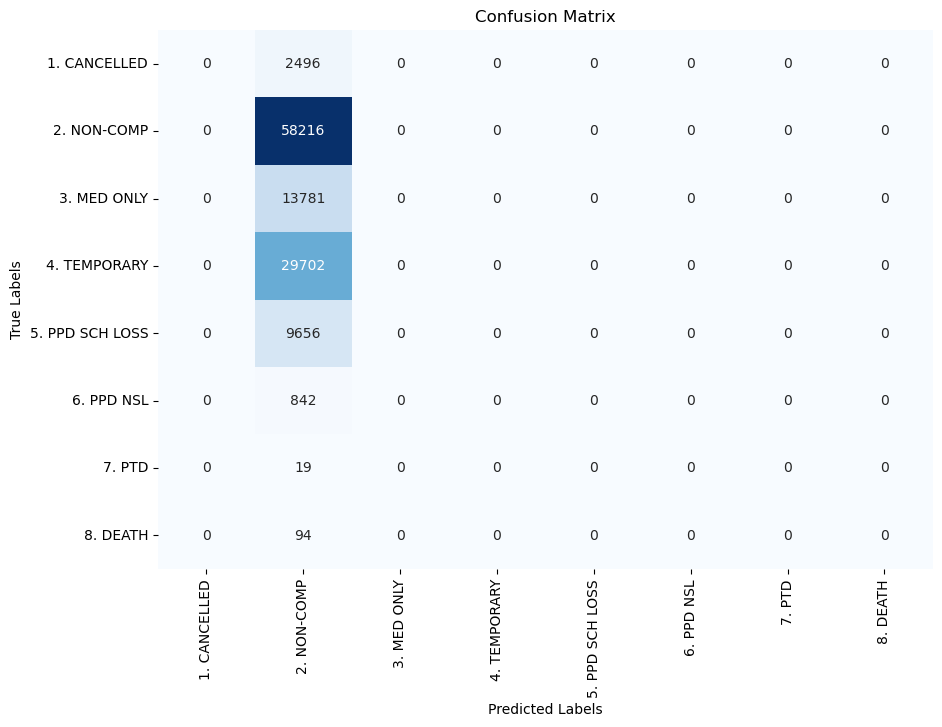

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Encode y_val and y_val_pred to be consistent (numeric) if needed
from sklearn.preprocessing import LabelEncoder

# Assume y_val is originally categorical (string) and we need to encode it
label_encoder = LabelEncoder()
y_val_encoded = label_encoder.fit_transform(y_val)  # Encode y_val
y_val_pred_encoded = label_encoder.transform(y_val_pred)  # Encode y_val_pred using the same encoder

# Calculate confusion matrix with consistent data types
conf_matrix = confusion_matrix(y_val_encoded, y_val_pred_encoded)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# The confusion matrix you provided shows that the model is overwhelmingly predicting a single class (specifically, "NON-COMP" in column 2) for almost all instances in the validation set. Here's what this result implies:

# Class Imbalance:

# The model predicts "NON-COMP" (second column) for nearly all true classes. This could indicate that your dataset is highly imbalanced, with "NON-COMP" potentially being the most frequent class.
# When a class is much more common than others, the model can become biased towards predicting that class since it minimizes the overall error rate by focusing on the majority class.
# Model Underfitting or Limited Learning:

# The model is not distinguishing between different classes effectively, suggesting it may be underfitting or failing to learn class-specific patterns.
# This often happens if the model is too simple or if important features are missing, making it challenging for the model to separate classes.
# Potential Data or Feature Issues:

# If you know your dataset is not very imbalanced, this result could also indicate issues with data preprocessing, feature selection, or encoding. Sometimes, improper encoding or scaling can lead the model to disregard important distinctions between classes.
# Recommendations to Improve the Model
# Check for Class Imbalance:

# Investigate the distribution of Claim Injury Type in your dataset to confirm if it’s highly imbalanced.
# If it is, consider using techniques like class weighting in logistic regression (class_weight='balanced') or oversampling/undersampling methods to balance the classes.
# Use More Complex Models or Adjust Parameters:

# Logistic regression may struggle with complex, multi-class problems. If logistic regression does not capture class-specific patterns well, you might try using more complex models, like Random Forests or Gradient Boosting.
# If you prefer sticking with logistic regression, try adjusting hyperparameters like C (for regularization) or increase the number of iterations to allow the model to learn better.
# Review and Engineer Features:

# Ensure that all relevant features are included, appropriately encoded, and scaled if needed.
# Consider feature engineering to create new variables that might help the model differentiate between classes.
# Evaluate with Class-Weighted Logistic Regression:

# You can set class_weight='balanced' in LogisticRegression to give more weight to underrepresented classes, making the model more sensitive to minority classes.